=== WAZE DATA STATISTICS ===
Dataset Shape: (5738, 26)
Total Records: 5,738
Total Columns: 26
Memory Usage: 5.1 MB

=== DATA QUALITY ===
Missing Values by Column:
  endTimeMillis: 5,738 (100.0%)
  startTimeMillis: 5,738 (100.0%)
  ttiFetchTimeMillis: 5,738 (100.0%)
  nThumbsUp: 5,460 (95.2%)
  city: 408 (7.1%)
  street: 165 (2.9%)
  reportDescription: 5,738 (100.0%)
  pubMillis: 5,738 (100.0%)

Columns with ALL missing values: 5
Columns with NO missing values: 18

=== CATEGORICAL VARIABLES DETAILED STATS ===

TYPE:
  Unique Values: 1
  Most Common: 'HAZARD' (5,738 times, 100.0%)
  Value Counts (Top 10):
    1. HAZARD: 5,738 (100.0%)

SUBTYPE:
  Unique Values: 6
  Most Common: 'HAZARD_ON_ROAD_OBJECT' (3,204 times, 55.8%)
  Value Counts (Top 10):
    1. HAZARD_ON_ROAD_OBJECT: 3,204 (55.8%)
    2. HAZARD_ON_ROAD_POT_HOLE: 1,383 (24.1%)
    3. HAZARD_ON_ROAD: 1,142 (19.9%)
    4. HAZARD_ON_SHOULDER_ANIMALS: 4 (0.1%)
    5. HAZARD_ON_ROAD_ROAD_KILL: 4 (0.1%)
    6. HAZARD_ON_SHOULDER: 1 (0.

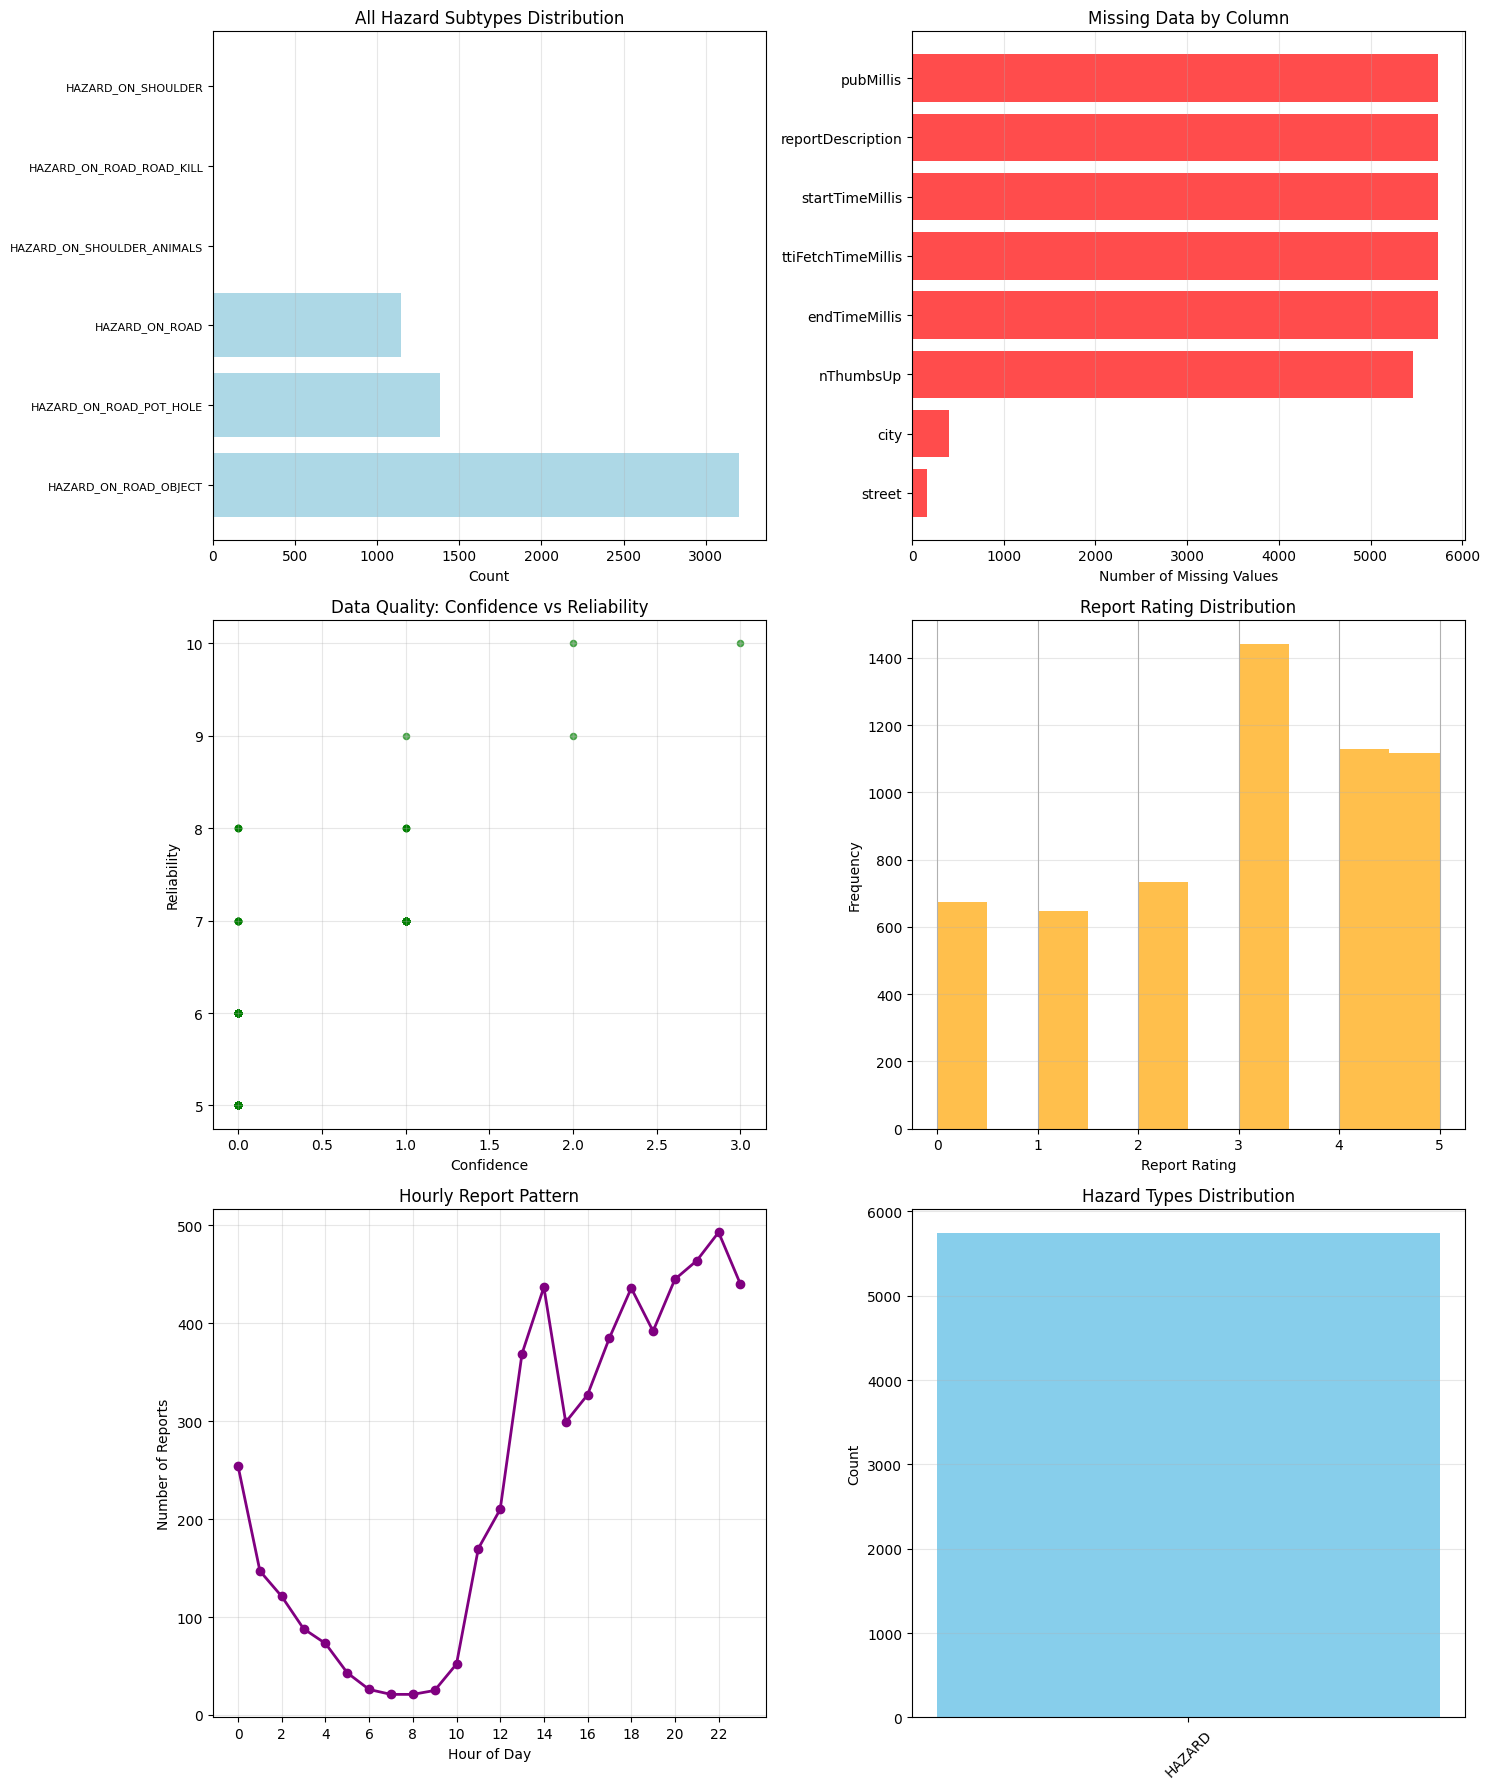


=== SUMMARY ===
This dataset contains 5,738 Waze hazard reports with 6 different subtypes.
Most reports are 'HAZARD' type with 'HAZARD_ON_ROAD_OBJECT' subtype.
Average confidence: 0.0/10, Average reliability: 5.1/10


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load data
hazards_df = pd.read_excel('Waze data type Hazards.xlsx')
with open('Waze.json', 'r') as f:
    waze_data = json.load(f)

# Clean columns
main_cols = [col for col in hazards_df.columns if '@type' not in col]
df = hazards_df[main_cols].copy()

print("=== WAZE DATA STATISTICS ===")

# BASIC INFO
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# DATA QUALITY ASSESSMENT
print(f"\n=== DATA QUALITY ===")
missing_data = df.isnull().sum()
print("Missing Values by Column:")
for col, missing in missing_data.items():
    if missing > 0:
        pct = (missing / len(df)) * 100
        print(f"  {col}: {missing:,} ({pct:.1f}%)")

print(f"\nColumns with ALL missing values: {len([col for col, missing in missing_data.items() if missing == len(df)])}")
print(f"Columns with NO missing values: {len([col for col, missing in missing_data.items() if missing == 0])}")

# CATEGORICAL VARIABLES ANALYSIS
print(f"\n=== CATEGORICAL VARIABLES DETAILED STATS ===")
categorical_cols = ['type', 'subtype', 'country', 'city', 'street', 'reportByMunicipalityUser']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col.upper()}:")
        print(f"  Unique Values: {df[col].nunique()}")
        print(f"  Most Common: '{df[col].mode()[0]}' ({df[col].value_counts().iloc[0]:,} times, {df[col].value_counts().iloc[0]/len(df)*100:.1f}%)")
        print(f"  Value Counts (Top 10):")
        for idx, (value, count) in enumerate(df[col].value_counts().head(10).items()):
            pct = (count / len(df)) * 100
            print(f"    {idx+1}. {value}: {count:,} ({pct:.1f}%)")

# CORRELATIONS
print(f"\n=== CORRELATIONS ===")
corr_cols = ['reportRating', 'confidence', 'reliability', 'roadType', 'magvar']
corr_matrix = df[corr_cols].corr()
print("Strong correlations (|r| > 0.3):")
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"  {corr_cols[i]} ↔ {corr_cols[j]}: {corr_val:.3f}")

# BUSINESS INSIGHTS
print(f"\n=== KEY BUSINESS INSIGHTS ===")
print(f"Data Quality Score: {((len(df) - df.isnull().sum().sum()) / (len(df) * len(df.columns)) * 100):.1f}%")
print(f"Average Confidence: {df['confidence'].mean():.1f}/10")
print(f"Average Reliability: {df['reliability'].mean():.1f}/10")
print(f"Municipal vs Citizen Reports: {df['reportByMunicipalityUser'].sum():,} municipal ({df['reportByMunicipalityUser'].mean()*100:.1f}%) vs {(~df['reportByMunicipalityUser']).sum():,} citizen ({(~df['reportByMunicipalityUser']).mean()*100:.1f}%)")

# High-quality reports
high_quality = df[(df['confidence'] >= 8) & (df['reliability'] >= 8)]
print(f"High-Quality Reports (conf≥8, rel≥8): {len(high_quality):,} ({len(high_quality)/len(df)*100:.1f}%)")

# JSON COMPARISON
print(f"\n=== JSON vs EXCEL COMPARISON ===")
print(f"Excel Records: {len(df):,}")
print(f"JSON Alerts: {len(waze_data['alerts'])}")
print(f"JSON Jams: {len(waze_data['jams'])}")
print(f"JSON Irregularities: {len(waze_data['irregularities'])}")

# CREATE VISUALIZATIONS
print(f"\n=== CREATING VISUALIZATIONS ===")

# Parse time for hourly analysis
df['startTime_parsed'] = pd.to_datetime(df['startTime'], format='%Y-%m-%d %H:%M:%S:%f')
df['hour'] = df['startTime_parsed'].dt.hour

# Create subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))

# 1. All Subtypes
subtype_counts = df['subtype'].value_counts()
ax1.barh(range(len(subtype_counts)), subtype_counts.values, color='lightblue')
ax1.set_yticks(range(len(subtype_counts)))
ax1.set_yticklabels(subtype_counts.index, fontsize=8)
ax1.set_xlabel('Count')
ax1.set_title('All Hazard Subtypes Distribution')
ax1.grid(axis='x', alpha=0.3)

# 2. Missing Data Visualization
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=True)
if len(missing_counts) > 0:
    ax2.barh(range(len(missing_counts)), missing_counts.values, color='red', alpha=0.7)
    ax2.set_yticks(range(len(missing_counts)))
    ax2.set_yticklabels(missing_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Missing Values')
    ax2.set_title('Missing Data by Column')
    ax2.grid(axis='x', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No Missing Data', ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_title('Missing Data by Column')

# 3. Confidence vs Reliability
ax3.scatter(df['confidence'], df['reliability'], alpha=0.6, s=20, color='green')
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Reliability')
ax3.set_title('Data Quality: Confidence vs Reliability')
ax3.grid(True, alpha=0.3)

# 4. Report Rating Distribution
df['reportRating'].hist(bins=10, ax=ax4, color='orange', alpha=0.7)
ax4.set_xlabel('Report Rating')
ax4.set_ylabel('Frequency')
ax4.set_title('Report Rating Distribution')
ax4.grid(axis='y', alpha=0.3)

# 5. Hourly Report Pattern
hourly_counts = df['hour'].value_counts().sort_index()
ax5.plot(hourly_counts.index, hourly_counts.values, marker='o', color='purple', linewidth=2)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Number of Reports')
ax5.set_title('Hourly Report Pattern')
ax5.grid(True, alpha=0.3)
ax5.set_xticks(range(0, 24, 2))

# 6. Type Distribution
type_counts = df['type'].value_counts()
ax6.bar(range(len(type_counts)), type_counts.values, color='skyblue')
ax6.set_xticks(range(len(type_counts)))
ax6.set_xticklabels(type_counts.index, rotation=45)
ax6.set_ylabel('Count')
ax6.set_title('Hazard Types Distribution')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"This dataset contains {len(df):,} Waze hazard reports with {df['subtype'].nunique()} different subtypes.")
print(f"Most reports are '{df['type'].mode()[0]}' type with '{df['subtype'].mode()[0]}' subtype.")
print(f"Average confidence: {df['confidence'].mean():.1f}/10, Average reliability: {df['reliability'].mean():.1f}/10")

In [8]:
# BETTER STATISTICAL ANALYSIS - Variables that actually matter

print("=== RELIABILITY LEVELS BY SUBTYPE ===")
for subtype in df['subtype'].value_counts().index:
   subset = df[df['subtype'] == subtype]['reliability']
   print(f"{subtype}:")
   print(f"  Mean reliability: {subset.mean():.2f}")
   print(f"  Median reliability: {subset.median():.2f}")

print("\n=== REPORT RATINGS BY SUBTYPE ===")
for subtype in df['subtype'].value_counts().index:
   subset = df[df['subtype'] == subtype]['reportRating']
   print(f"{subtype}:")
   print(f"  Mean rating: {subset.mean():.2f}")
   print(f"  Median rating: {subset.median():.2f}")

print("\n=== MUNICIPAL vs CITIZEN REPORTS BY SUBTYPE ===")
municipal_by_subtype = df.groupby('subtype')['reportByMunicipalityUser'].agg(['count', 'sum', 'mean'])
municipal_by_subtype['citizen_reports'] = municipal_by_subtype['count'] - municipal_by_subtype['sum']
municipal_by_subtype['municipal_pct'] = municipal_by_subtype['mean'] * 100

print(municipal_by_subtype[[ 'citizen_reports', 'municipal_pct']].round(1))

print("\n=== ROAD TYPE ANALYSIS ===")
print("Road types where hazards occur:")
print(df['roadType'].value_counts())
print(f"\nMean road type: {df['roadType'].mean():.1f}")
print(f"Most common road type: {df['roadType'].mode()[0]}")

print("\n=== THUMBS UP ANALYSIS ===")
thumbs_data = df['nThumbsUp'].dropna()
if len(thumbs_data) > 0:
   print(f"Reports with thumbs up: {len(thumbs_data)} out of {len(df)} ({len(thumbs_data)/len(df)*100:.1f}%)")
   print(f"Average thumbs up per report: {thumbs_data.mean():.2f}")
   print(f"Max thumbs up on a report: {thumbs_data.max()}")
else:
   print("No thumbs up data available")

=== RELIABILITY LEVELS BY SUBTYPE ===
HAZARD_ON_ROAD_OBJECT:
  Mean reliability: 5.09
  Median reliability: 5.00
HAZARD_ON_ROAD_POT_HOLE:
  Mean reliability: 5.08
  Median reliability: 5.00
HAZARD_ON_ROAD:
  Mean reliability: 5.06
  Median reliability: 5.00
HAZARD_ON_SHOULDER_ANIMALS:
  Mean reliability: 5.00
  Median reliability: 5.00
HAZARD_ON_ROAD_ROAD_KILL:
  Mean reliability: 5.75
  Median reliability: 5.50
HAZARD_ON_SHOULDER:
  Mean reliability: 5.00
  Median reliability: 5.00

=== REPORT RATINGS BY SUBTYPE ===
HAZARD_ON_ROAD_OBJECT:
  Mean rating: 2.95
  Median rating: 3.00
HAZARD_ON_ROAD_POT_HOLE:
  Mean rating: 3.17
  Median rating: 3.00
HAZARD_ON_ROAD:
  Mean rating: 2.34
  Median rating: 3.00
HAZARD_ON_SHOULDER_ANIMALS:
  Mean rating: 1.50
  Median rating: 1.00
HAZARD_ON_ROAD_ROAD_KILL:
  Mean rating: 3.25
  Median rating: 3.00
HAZARD_ON_SHOULDER:
  Mean rating: 2.00
  Median rating: 2.00

=== MUNICIPAL vs CITIZEN REPORTS BY SUBTYPE ===
                            citizen_re

In [11]:
# PROPER JSON DATA EXPLORATION
print("=== DETAILED JSON ANALYSIS ===")

# Explore alerts
print("ALERTS DATA:")
if len(waze_data['alerts']) > 0:
    alerts_df = pd.DataFrame(waze_data['alerts'])
    print(f"Alerts count: {len(alerts_df)}")
    print(f"Alert columns: {list(alerts_df.columns)}")
    
    if 'type' in alerts_df.columns:
        print("Alert types:")
        print(alerts_df['type'].value_counts())
    
    if 'subtype' in alerts_df.columns:
        print("Alert subtypes:")
        print(alerts_df['subtype'].value_counts())
    
    print("\nSample alert:")
    print(alerts_df.iloc[0])

# Explore jams
print(f"\nJAMS DATA:")
if len(waze_data['jams']) > 0:
    jams_df = pd.DataFrame(waze_data['jams'])
    print(f"Jams count: {len(jams_df)}")
    print(f"Jam columns: {list(jams_df.columns)}")
    
    if 'level' in jams_df.columns:
        print("Jam levels:")
        print(jams_df['level'].value_counts())
    
    if 'length' in jams_df.columns:
        print(f"Average jam length: {jams_df['length'].mean():.1f}")
    
    print("\nSample jam:")
    print(jams_df.iloc[0])

# Explore irregularities
print(f"\nIRREGULARITIES DATA:")
if len(waze_data['irregularities']) > 0:
    irreg_df = pd.DataFrame(waze_data['irregularities'])
    print(f"Irregularities count: {len(irreg_df)}")
    print(f"Irregularity columns: {list(irreg_df.columns)}")
    
    if 'type' in irreg_df.columns:
        print("Irregularity types:")
        print(irreg_df['type'].value_counts())
    
    print("\nSample irregularity:")
    print(irreg_df.iloc[0])

# Compare JSON vs Excel
print(f"\n=== JSON vs EXCEL COMPARISON ===")
print(f"Excel hazards: {len(df)} records")
print(f"JSON alerts: {len(waze_data['alerts'])} records")
print("These are likely different data sources or time periods!")

=== DETAILED JSON ANALYSIS ===
ALERTS DATA:
Alerts count: 56
Alert columns: ['country', 'reportRating', 'reportByMunicipalityUser', 'confidence', 'reliability', 'type', 'fromNodeId', 'uuid', 'roadType', 'magvar', 'subtype', 'street', 'toNodeId', 'location', 'pubMillis', 'city', 'reportDescription']
Alert types:
type
HAZARD    56
Name: count, dtype: int64
Alert subtypes:
subtype
HAZARD_ON_SHOULDER_CAR_STOPPED      27
HAZARD_ON_ROAD_CONSTRUCTION         17
HAZARD_ON_ROAD_CAR_STOPPED           3
HAZARD_ON_ROAD_OBJECT                3
HAZARD_ON_ROAD_EMERGENCY_VEHICLE     2
HAZARD_ON_ROAD_LANE_CLOSED           2
HAZARD_ON_ROAD                       1
HAZARD_ON_ROAD_POT_HOLE              1
Name: count, dtype: int64

Sample alert:
country                                                       US
reportRating                                                   2
reportByMunicipalityUser                                   false
confidence                                                     3
reliab

=== JSON ALERTS STATISTICAL ANALYSIS ===
JSON Alerts: 56 records
JSON Jams: 52 records
JSON Irregularities: 2 records

=== ALERTS DETAILED STATS ===

ALERT SUBTYPES:
  Unique subtypes: 8
  HAZARD_ON_SHOULDER_CAR_STOPPED: 27 (48.2%)
  HAZARD_ON_ROAD_CONSTRUCTION: 17 (30.4%)
  HAZARD_ON_ROAD_CAR_STOPPED: 3 (5.4%)
  HAZARD_ON_ROAD_OBJECT: 3 (5.4%)
  HAZARD_ON_ROAD_EMERGENCY_VEHICLE: 2 (3.6%)
  HAZARD_ON_ROAD_LANE_CLOSED: 2 (3.6%)
  HAZARD_ON_ROAD: 1 (1.8%)
  HAZARD_ON_ROAD_POT_HOLE: 1 (1.8%)

RELIABILITY (JSON):
  Mean: 8.18
  Median: 9.50
  Range: 5 - 10

CONFIDENCE (JSON):
  Mean: 2.29
  Median: 2.00
  Range: 0 - 5

REPORT RATINGS (JSON):
  Mean: 1.66
  Median: 1.50
  Distribution: {0: 24, 1: 4, 2: 9, 3: 10, 4: 4, 5: 5}

=== JAMS DETAILED STATS ===

JAM LEVELS:
  Level 1: 1 (1.9%)
  Level 2: 5 (9.6%)
  Level 3: 11 (21.2%)
  Level 4: 2 (3.8%)
  Level 5: 33 (63.5%)

JAM LENGTHS:
  Mean length: 807.1 meters
  Median length: 212.5 meters
  Shortest jam: 38 meters
  Longest jam: 8173 meters


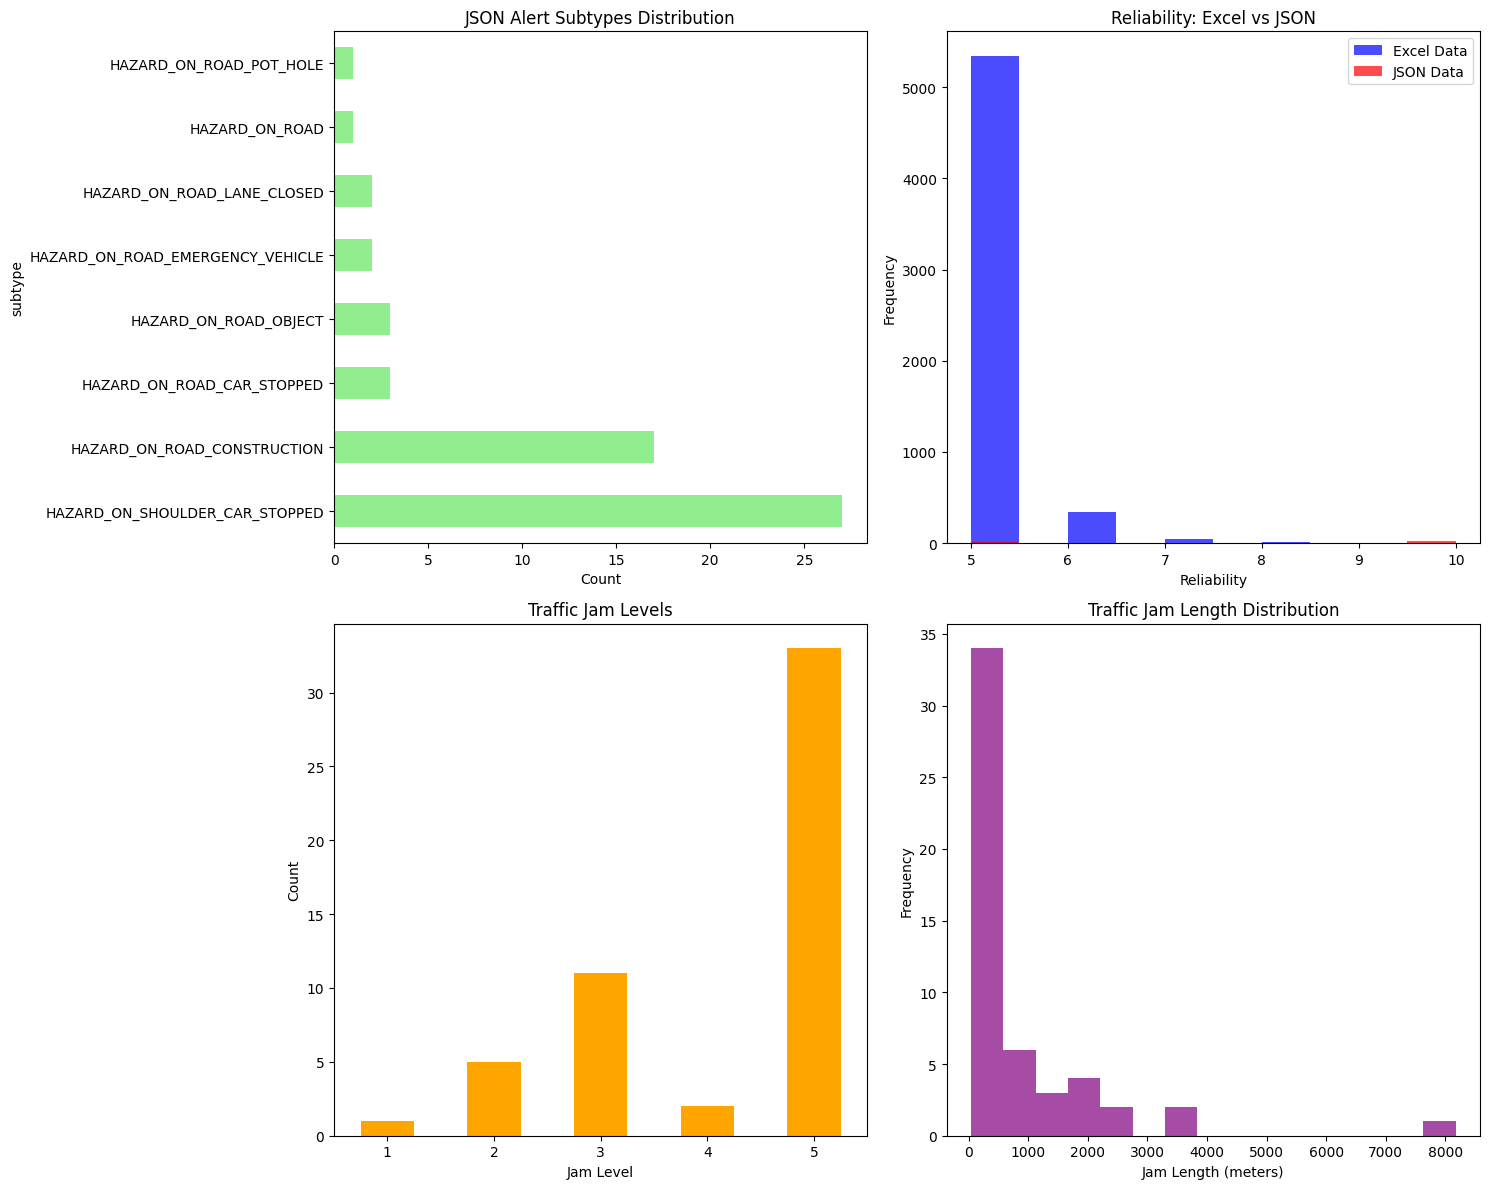


=== JSON vs EXCEL KEY DIFFERENCES ===
Data Volume: Excel has 5738 records vs JSON 56 alerts
Confidence: Excel avg 0.01 vs JSON avg 2.29
Reliability: Excel avg 5.08 vs JSON avg 8.18
Report Rating: Excel avg 2.88 vs JSON avg 1.66

JSON has additional data types that Excel doesn't:
  - 52 traffic jams
  - 2 traffic irregularities


In [12]:
# JSON DATA STATISTICAL ANALYSIS
print("=== JSON ALERTS STATISTICAL ANALYSIS ===")

# Convert JSON data to DataFrames
alerts_df = pd.DataFrame(waze_data['alerts'])
jams_df = pd.DataFrame(waze_data['jams'])
irreg_df = pd.DataFrame(waze_data['irregularities'])

print(f"JSON Alerts: {len(alerts_df)} records")
print(f"JSON Jams: {len(jams_df)} records") 
print(f"JSON Irregularities: {len(irreg_df)} records")

# ALERTS ANALYSIS
print("\n=== ALERTS DETAILED STATS ===")

print(f"\nALERT SUBTYPES:")
print(f"  Unique subtypes: {alerts_df['subtype'].nunique()}")
for subtype, count in alerts_df['subtype'].value_counts().items():
   pct = (count / len(alerts_df)) * 100
   print(f"  {subtype}: {count} ({pct:.1f}%)")

print(f"\nRELIABILITY (JSON):")
print(f"  Mean: {alerts_df['reliability'].mean():.2f}")
print(f"  Median: {alerts_df['reliability'].median():.2f}")
print(f"  Range: {alerts_df['reliability'].min()} - {alerts_df['reliability'].max()}")

print(f"\nCONFIDENCE (JSON):")
print(f"  Mean: {alerts_df['confidence'].mean():.2f}")
print(f"  Median: {alerts_df['confidence'].median():.2f}")
print(f"  Range: {alerts_df['confidence'].min()} - {alerts_df['confidence'].max()}")

print(f"\nREPORT RATINGS (JSON):")
print(f"  Mean: {alerts_df['reportRating'].mean():.2f}")
print(f"  Median: {alerts_df['reportRating'].median():.2f}")
print(f"  Distribution: {alerts_df['reportRating'].value_counts().sort_index().to_dict()}")

# JAMS ANALYSIS
print("\n=== JAMS DETAILED STATS ===")

print(f"\nJAM LEVELS:")
for level, count in jams_df['level'].value_counts().sort_index().items():
   pct = (count / len(jams_df)) * 100
   print(f"  Level {level}: {count} ({pct:.1f}%)")

print(f"\nJAM LENGTHS:")
print(f"  Mean length: {jams_df['length'].mean():.1f} meters")
print(f"  Median length: {jams_df['length'].median():.1f} meters")
print(f"  Shortest jam: {jams_df['length'].min()} meters")
print(f"  Longest jam: {jams_df['length'].max()} meters")

print(f"\nJAM SPEEDS:")
print(f"  Mean speed: {jams_df['speedKMH'].mean():.1f} km/h")
print(f"  Median speed: {jams_df['speedKMH'].median():.1f} km/h")

# IRREGULARITIES ANALYSIS
print("\n=== IRREGULARITIES DETAILED STATS ===")
print(f"\nIRREGULARITY TYPES:")
for irr_type, count in irreg_df['type'].value_counts().items():
   print(f"  {irr_type}: {count}")

print(f"\nDELAY IMPACT:")
print(f"  Mean delay: {irreg_df['delaySeconds'].mean():.1f} seconds")
print(f"  Mean length: {irreg_df['length'].mean():.1f} meters")
print(f"  Drivers affected: {irreg_df['driversCount'].sum()} total")

# CREATE VISUALIZATIONS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. JSON Alert Subtypes
alerts_df['subtype'].value_counts().plot(kind='barh', ax=ax1, color='lightgreen')
ax1.set_title('JSON Alert Subtypes Distribution')
ax1.set_xlabel('Count')

# 2. JSON vs Excel Reliability Comparison
ax2.hist(df['reliability'], bins=10, alpha=0.7, label='Excel Data', color='blue')
ax2.hist(alerts_df['reliability'], bins=10, alpha=0.7, label='JSON Data', color='red')
ax2.set_xlabel('Reliability')
ax2.set_ylabel('Frequency')
ax2.set_title('Reliability: Excel vs JSON')
ax2.legend()

# 3. Jam Levels
jams_df['level'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='orange')
ax3.set_title('Traffic Jam Levels')
ax3.set_xlabel('Jam Level')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=0)

# 4. Jam Lengths Distribution
ax4.hist(jams_df['length'], bins=15, alpha=0.7, color='purple')
ax4.set_xlabel('Jam Length (meters)')
ax4.set_ylabel('Frequency')
ax4.set_title('Traffic Jam Length Distribution')

plt.tight_layout()
plt.show()

# COMPARISON SUMMARY
print("\n=== JSON vs EXCEL KEY DIFFERENCES ===")
print(f"Data Volume: Excel has {len(df)} records vs JSON {len(alerts_df)} alerts")
print(f"Confidence: Excel avg {df['confidence'].mean():.2f} vs JSON avg {alerts_df['confidence'].mean():.2f}")
print(f"Reliability: Excel avg {df['reliability'].mean():.2f} vs JSON avg {alerts_df['reliability'].mean():.2f}")
print(f"Report Rating: Excel avg {df['reportRating'].mean():.2f} vs JSON avg {alerts_df['reportRating'].mean():.2f}")

print(f"\nJSON has additional data types that Excel doesn't:")
print(f"  - {len(jams_df)} traffic jams")
print(f"  - {len(irreg_df)} traffic irregularities")